# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias, Nidham Gazagnadou
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## <font color='red'>VERY IMPORTANT: if some of the following instructions is not followed, it will be penalized</font>

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 27th of november at 21:55**, using the **moodle platform**.
- Only **one submission by pair** of students
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "habis"
ln1 = "antoine"
fn2 = "mathis"
ln2 = "chagneux"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_antoine_habis_and_chagneux_mathis.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[0. Test Numba](#numba)<br>
[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [2]:
%matplotlib inline

In [3]:
from time import time
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
import numba # available at: http://numba.pydata.org/numba-doc/latest/user/installing.html
from numba import njit

In [4]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='numba'></a>
## 0. Make sure Numba is correctly installed
Instructions available at: http://numba.pydata.org/numba-doc/latest/user/installing.html

In [5]:
print(numba.__version__) # Your version of Numba


0.45.1


In [6]:
@njit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

x = np.arange(100).reshape(10, 10)
go_fast(x); # Running a first time the function to compile it

Iteration time of the Numba-compiled function.

In [7]:
%timeit go_fast(x)

813 ns ± 9.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Numba-compiled function have a special `.py_func` attribute which is the original uncompiled Python function.  Iteration time of the uncompiled function should be greater.

In [8]:
%timeit go_fast.py_func(x)

17 µs ± 651 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [9]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    n = A.shape[0]
    a_i = A[i]
    return (np.dot(a_i,x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    n = A.shape[0]
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    n = A.shape[0]
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    n = A.shape[0]
    return norm(A, ord=2) ** 2 / n + lbda

In [10]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    n = A.shape[0]
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    n = A.shape[0]
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    n = A.shape[0]
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    n = A.shape[0]
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [11]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [12]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [13]:
toeplitz(0.5 ** np.arange(0, 3))

array([[1.  , 0.5 , 0.25],
       [0.5 , 1.  , 0.5 ],
       [0.25, 0.5 , 1.  ]])

In [14]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

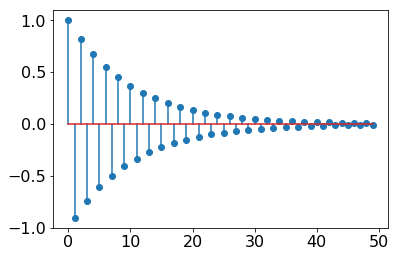

In [15]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [16]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

2.09011313176905e-06

In [17]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

4.133922252895733e-07

### Choice of the model

In [18]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [19]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.06419479100822428


### Get a very precise minimum to compute distances to minimum

In [20]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5322047991440031
1.3756067087211841e-08


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [21]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [22]:
# Number of full batch iterations
n_iter = 50

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Q1) Fill in the iteration of the GD solver in the cell below

In [23]:
@njit
def gd(x_init, grad, n_iter=50, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x -= step*grad(x, *args)
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [24]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipschitz constant of $\nabla f$, see above)

*QUESTION*:
- Q2) Fill in the iteration of the AGD solver in the cell below

In [25]:
@njit
def agd(x_init, grad, n_iter=50, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
            
        ### TODO
        x_old = x.copy()
        t_old = t
        
        x = y - step*grad(y, *args)
        t = (1 + np.sqrt(1+4*(t**2)))/2
        y = x + (t_old-1)*(x-x_old)/t
        ### END TODO
        
    return x, x_list

In [26]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [27]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [28]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b


x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [50]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("$f(x_k) - f(x^*)$")
    plt.grid()
    plt.legend(solvers)
    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")
    plt.grid()
    plt.legend(solvers)
    

def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")
        plt.grid()
    plt.legend(solvers)

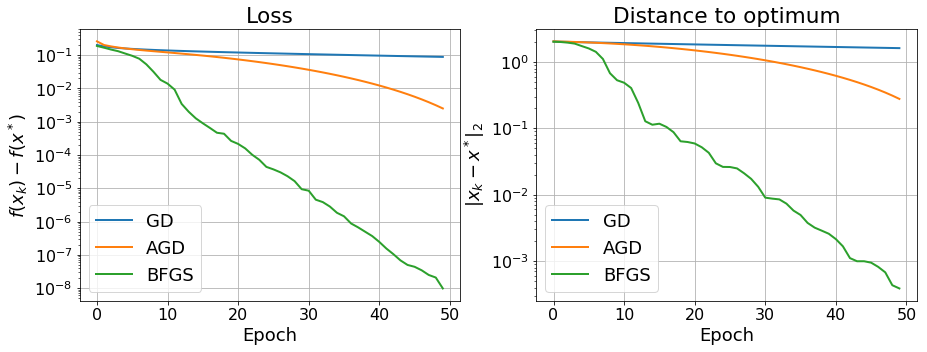

In [51]:
monitors = [monitor_gd, monitor_agd, monitor_bfgs]

solvers = ["GD", "AGD", "BFGS"]

plot_epochs(monitors, solvers)

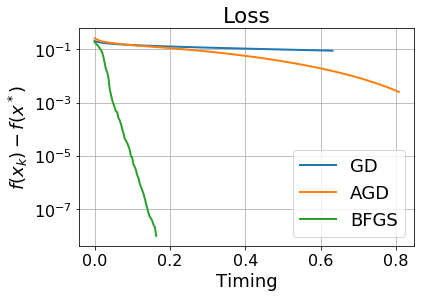

In [52]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Q3) Give some first conclusions about the batch solver studied here
- Q4) What do you observe about AGD? is it suprising ?

## Q3) 

* All of these solvers are full batch meaning that we can compare them in terms of epoch.

* We see that AGD does converge closer to the true minimum than GD in a lesser number of epochs, and BFGS is far better undoubtedly. 
* We also see that BFGS is even better in terms of timing, meaning that it is much more computationnaly optimized. Not only is the convergence theoretically better, the implementation makes it work very fast on a computer



## Q4) 
* AGD is supposed to take us from O(1/T) to O(1/T²) and we do observe this change in shape for the epochs if we ignore the local shape (which is the next remark).
* We can see the periodic jumps that AGD makes. We do not know a theoretical reason for the efficiency of the AGD algorithm as R. Gower told us in class, but we can imagine that these jumps are the way the algorithm reaches its better speed : it is not purely descending as such. 

<a id='stoc'></a> 
## 4. Stochastic methods
*WARNING*: for stochastic methods ``n_iter`` corresponds to the number of epochs (number of full pass across the data)

In [32]:
n_iter = 50 # here corresponds to the number of epochs

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Q5) Fill in the iteration of the SGD solver in the cell below

In [33]:
@njit
def sgd(x_init, iis, grad_i, n_iter=50, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x = x - step*grad_i(i, x, *args)/np.sqrt(idx+1)
        ### END TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [34]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Q6) Fill in the iteration of the SAG solver in the cell below

In [35]:
@njit
def sag(x_init, iis, grad_i, n_iter=50, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    n = args[0].shape[0]
    d = args[0].shape[1]
    gradient_memory = np.zeros((n,d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        averaged_gradient = averaged_gradient - gradient_memory[i]/n
        gradient_memory[i] = grad_i(i, x, *args)
        averaged_gradient = averaged_gradient + gradient_memory[i]/n
        x = x - step*averaged_gradient
        ### END OF TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
            
    return x, x_list

In [36]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Q7) Fill in the iteration of the SVRG solver in the cell below

In [37]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter = 50, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    n = args[0].shape[0]
    d = args[0].shape[1]
    
    for idx in range(n_iter):
        ### TODO
        
        if idx == 0 or idx % store_every == 0:
            x_old = x.copy()
            mu = grad(x_old, *args)

        i = iis[idx]
        x = x - step*(grad_i(i, x, *args) - grad_i(i, x_old, *args) + mu)
                        
        ### END TODO        
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x_old.copy())
            
            
    return x, x_list

In [38]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, n_iter * n, step, args=(A, b, lbda))

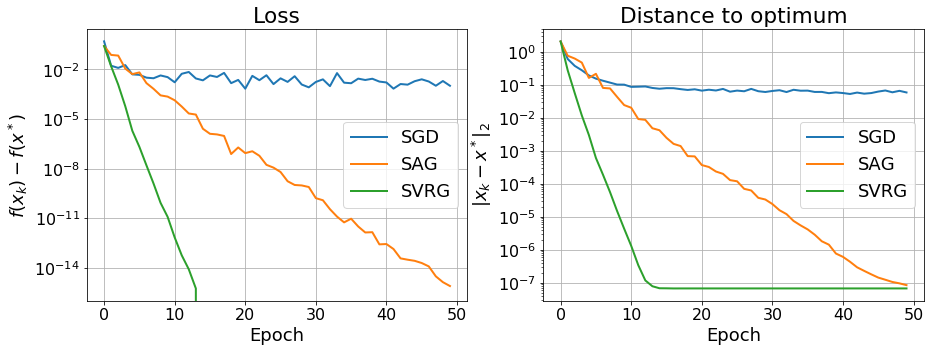

In [53]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

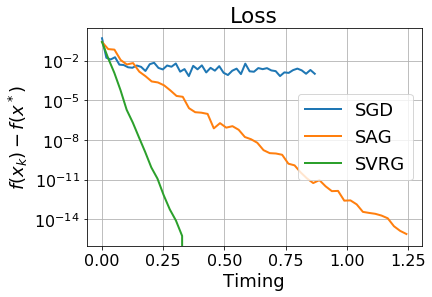

In [40]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Q8) Compare the converge (on the different plots) of the stochastic methods you implemented

## Q8)

* We see that SGD doesn't get very close to the true minimizer compared to the other methods. This is, as we saw, caused by the variance created when calculating the gradient for each data point which makes the progression very noisy and also, in the end, unable to reach the true minimizer close enough. We can see the shape of SGD being initially fast and slower later as we saw in the course. This justifies the need for more complex methods as SAG and SVRG.


* In terms of duration, the SVRG algorithm takes a lot less time to reach its minimizer than SAG. Possibily the SVRG algorithm is faster because it takes less time to store and access the data: only needs to compute a full gradient each n iteration and access it, while SAG stores single gradients of the last n iterations.

* With SAG the covarite function is the mean over the last n gradients on the points we've reached, so we give the same importance to the gradient we computed n steps before and the last one.

<a id='comp'></a> 
## 5. Numerical comparison

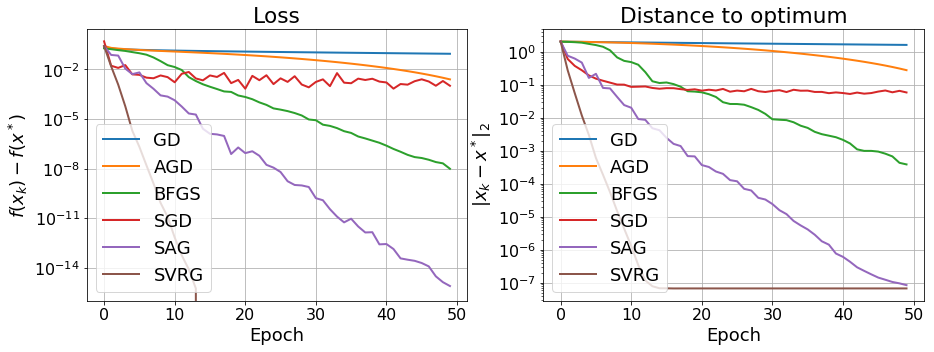

In [54]:
monitors = [monitor_gd, monitor_agd, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

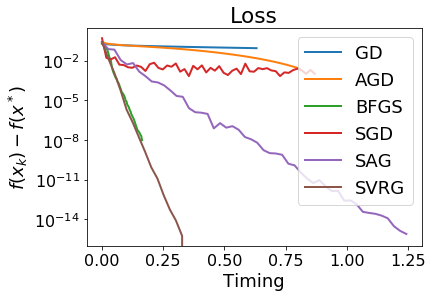

In [55]:
plot_time(monitors, solvers)

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:

For all the following questions, try to show only **FEW INFORMATIVE FIGURES** that highlight your conclusions.
- Q9) Compare the deterministic and the stochastic gradient methods. Comment your results.
- Q10) Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Q11) Look carefuly on how the data are generated in functions  ``simu_linreg`` and ``simu_logreg``. Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Q12) Change the number of data points $n$ and the number of data samples $d$ and compare your results. Comment.
- Q13) Conclude on the performance on the implemented methods. Are their "regimes" for which some methods are faster than others?
- Q14) Are there different behaviours between the deterministic methods? What about the stochastic ones?
- Q15) Compare the memory, the number of hyper-parameters to tune and the ease of implementation of each algorithm. According to this, in which configuration do you think a user should use deterministic method rather than a stochastic one, and vice-versa?

Pour la dernière question : juste une comparaison théorique
Si on montre des courbes et qu'on n'arrive pas à justifier pquoi pas même si c'est pas le mieux
Pour les questions sur la corrélation, regarder comment les données sont générées

## Question 9

The deterministic methods are  GD, AGD and L-BFGS.
They are deterministic as the gradients computed are the true gradients and not an approximation of them so they converge to the true minimizer, however the convergence is quite slow.

$\underline{For~the~determinist~methods:}$

**GD** is slow and is still very far from the true value after 50 iterations.

**AGD** is better than GD in terms of convergence  ($\approx 10^{-1}$) but a bit slower to compute 50 epochs with its stopping criterion

**L-BFGS** is faster and better in terms of convergence  ($\approx 10^{-3}$)

$\underline{For~the~stochastic~methods:}$

**SGD**: it is a bit better than AGD  after 50 epochs but suffers from high variance and can't go any much better than it's approximation after 30 epochs whereas AGD is getting closer faster through epochs.The shape of SGD is furthermore really noisy due to high variance and even though we are at the 50th epoch the loss can have big ups and downs. However it is still more precise than GD in that low number of iterations because the jumps allow it to get close to the minimizer faster.

**SAG** is quite slow to reach its stopping criterion but one of the best in terms of convergence to the minimizer ($\approx 10^{-7}$) after 50 epochs.

**SVRG** is by far the best algorithm reaching the same precision as SAG in much less time.



**We see that the use of stochastic methods to get closer to the minimizer brings very good algorithms. However a very clever deterministic method (L-BFGS) might be better than the simplest stochastic method (SGD), but a more complex stochastic method (SVRG) beats everything in our conditions apparently.**

Here we are going to write a function to change parameters easily:

In [43]:
###This function allows us to change the parameters as we want and select the curves we want to plot
def change_ridge_parameter(lbda, n_iter = 50, corr = 0.5, methods = [7],n = 10000, d = 50,epochs = True, timing = False):
    idx = np.arange(d)
    # Ground truth coefficients of the model
    x_model_truth = (-1)**idx * np.exp(-idx / 10.)
    ###Generation of the data
    A, b = simu_linreg(x_model_truth, n, std=1., corr = corr)
    ####Findind the true minimum
    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)
    
    
    monitors = []
    solvers = []
    ##########GD###########
    if (1 in methods) or(7 in methods):
        x_init = np.zeros(d)
        step = 1. / lipschitz_linreg(A, b, lbda)
        monitor_gd1 = monitor(gd, loss, x_min, (A, b ,lbda))
        monitor_gd1.run(x_init, grad, n_iter, step, args=(A, b, lbda))
        monitors.append(monitor_gd1)
        solvers.append('GD')
    ##########AGD###########
    if (2 in methods) or(7 in methods):
        x_init = np.zeros(d)
        step = 1. / lipschitz_linreg(A, b, lbda)
        monitor_agd1 = monitor(agd, loss, x_min, (A, b ,lbda))
        monitor_agd1.run(x_init, grad, n_iter, step, args=(A, b, lbda))
        monitors.append(monitor_agd1)
        solvers.append('AGD')
    ##########BFGS###########
    if (3 in methods) or(7 in methods):
        x_init = np.zeros(d)
        monitor_bfgs1 = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
        monitor_bfgs1.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)
        monitors.append(monitor_bfgs1)
        solvers.append('BFGS')
    ##########SGD###########
    if (4 in methods) or(7 in methods):
        x_init = np.zeros(d)
        step0 = 1e-1
        iis = np.random.randint(0, n, n * n_iter)
        monitor_sgd1 = monitor(sgd, loss, x_min, (A, b ,lbda))
        monitor_sgd1.run(x_init, iis, grad_i, n_iter * n, step0, args=(A, b, lbda))
        monitors.append(monitor_sgd1)
        solvers.append('SGD')
    ##########SAGA###########
    if (5 in methods) or(7 in methods):
        x_init = np.zeros(d)
        max_squared_sum = np.max(np.sum(A ** 2, axis=1))
        step = 1.0 / (max_squared_sum + lbda)
        iis = np.random.randint(0, n, n * n_iter)
        monitor_sag1 = monitor(sag, loss, x_min, (A, b ,lbda))
        monitor_sag1.run(x_init, iis, grad_i, n_iter * n, step, store_every = n, args=(A, b, lbda))
        monitors.append(monitor_sag1)
        solvers.append('SAG')
    ##########SVRG###########
    if (6 in methods) or(7 in methods):
        x_init = np.zeros(d)
        max_squared_sum = np.max(np.sum(A ** 2, axis=1))
        step = 1.0 / (max_squared_sum + lbda)
        iis = np.random.randint(0, n, n * n_iter)
        monitor_svrg1 = monitor(svrg, loss, x_min, (A, b ,lbda))
        monitor_svrg1.run(x_init, iis, grad, grad_i, n_iter * n, step, store_every = n, args=(A, b, lbda))
        monitors.append(monitor_svrg1)
        solvers.append('SVRG')        
    #############PLOTS#######
    if epochs:
        plot_epochs(monitors, solvers)
        plt.grid()
        plt.show()
    if timing:
        plot_time(monitors, solvers)
        plt.grid()
        plt.show()

## Question 10

### Let's change the ridge parameter:

**Low Ridge $\lambda= \frac{1}{n}$**

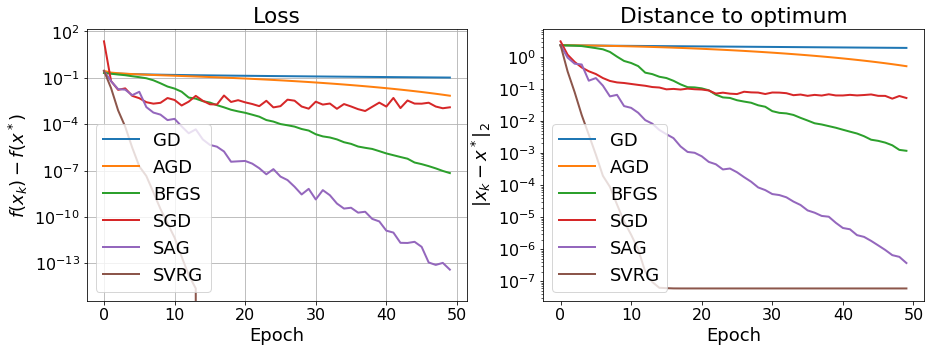

In [56]:
lbda = 1./n
change_ridge_parameter(lbda, n_iter = 50, corr = 0.9, methods = [7])

**High Ridge $\lambda= \frac{1}{\sqrt{n}}$**

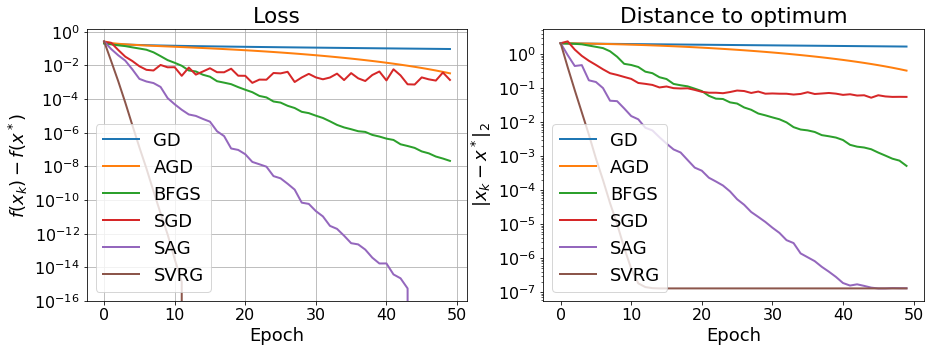

In [57]:
lbda = 1./np.sqrt(n)
change_ridge_parameter(lbda, n_iter = 50, corr = 0.9, methods = [7])

We can see that the Low ridge affected the accuracy of **SGD** and **SAG** and also the speed in terms of epoch of the **SVRG**.

With Low Ridge the distance to the optimum with **SGD** is a bit bigger than the one found with High Ridge. Also, while **SAG** had the same distance to the minimum as **SVRG** in 50 epochs with High Ridge, the Low ridge made it harder to converge towards this value in 50 epochs.

Finally we can see that with Low Ridge **SVRG** converges less quickly to it's optimal value than before.


All in all a lower penalization term mostly deteriorates the performance of the algorithms.

## Question 11

In simulinreg, the datas A are built using samples from a multivariate normal distribution with a matrix of covariance $\Sigma$ 
such that the features $i$ and $j$ have a covariance equal to $\frac{1}{|i - j|+1}corr$. So the more corr is high the more the features are correlated to each others.

$y_{true}$ is computed  by calculating $y_{true} = A~x_{true} + \epsilon$ \{$\epsilon$   noise.


for simulogreg it's the same operation however $y_{true}$ is equal to the sign of the $y_{true}$ mentionned before.

correlation = 0.1


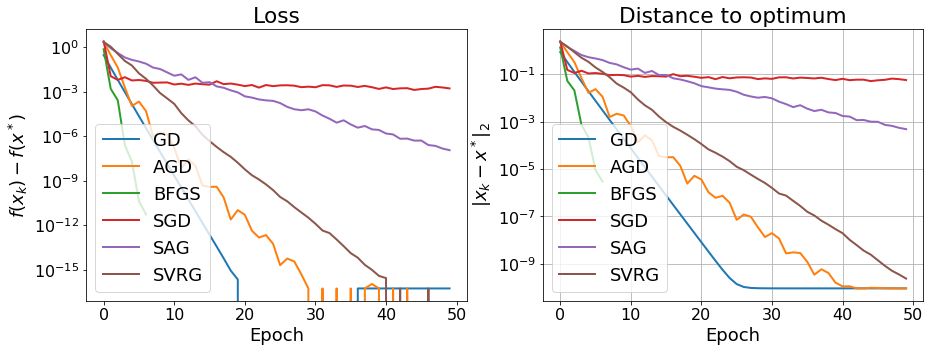

correlation = 0.8


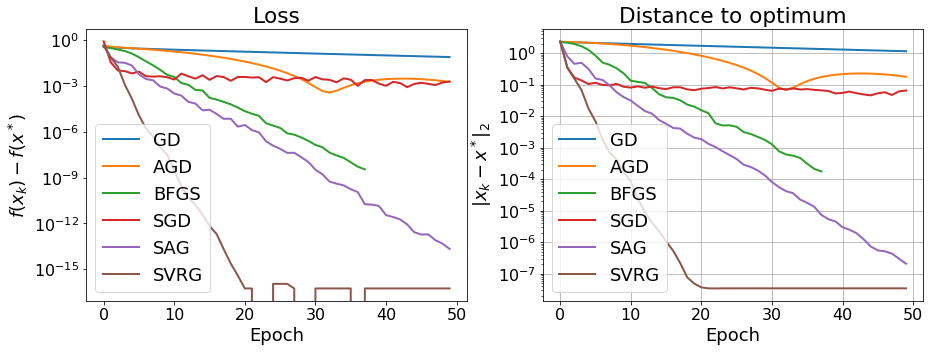

In [46]:
lbda = 1./n
corr = [0.1,0.8]
for u in corr:
    print('correlation = '+str(u))
    change_ridge_parameter(lbda, n_iter = 50, corr = u, methods = [7])
    plt.show()

Most algorithms are affected by the correlation change and perform badly when data is highly correlated.
We can see that when correlation is getting bigger GD and AGD suffer from a big decreasing of the convergence speed towards the minimizer whereas the other methods are less affected by this change.

If the features are less correlated, there are less sets of coefficients giving the same solution, so every gradient step taken is more efficient.

To see the influence of the correlation parameter we are going to choose 2 methods: one probabilistic and one determinist: AGD and SAG

We can see in the figures that while correlation is increasing **AGD** is getting less and less effective : its convergence speed in terms of epochs is decreasing and the distance to the optimum is getting bigger also.
We also observe that, the less the correlation is, the more bounces we observe in the curve of **AGD**, this is coherent with our idea of "more efficient" steps when the features are less correlated (though it is only an intuitive idea).


For **SAG**  when we increase the correlation the distance to the optimum decreases. The method is more effective.

## Question 12

We test the algorithms for 10 times less features and 10 times more than what we previously had, with a mild correlation.

the number of features is  d = 10


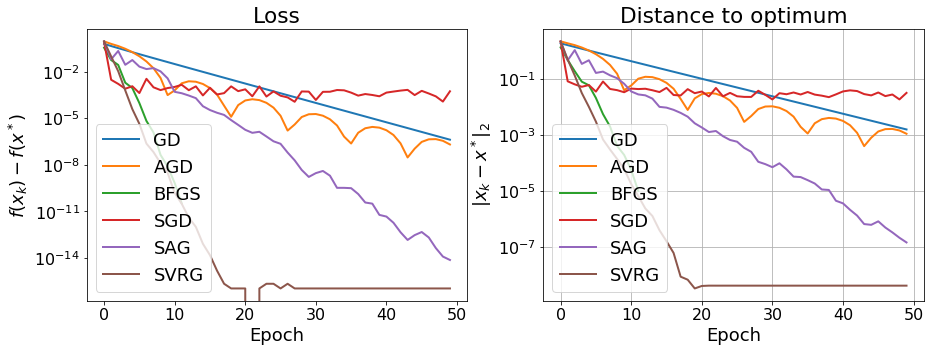

the number of features is  d = 100


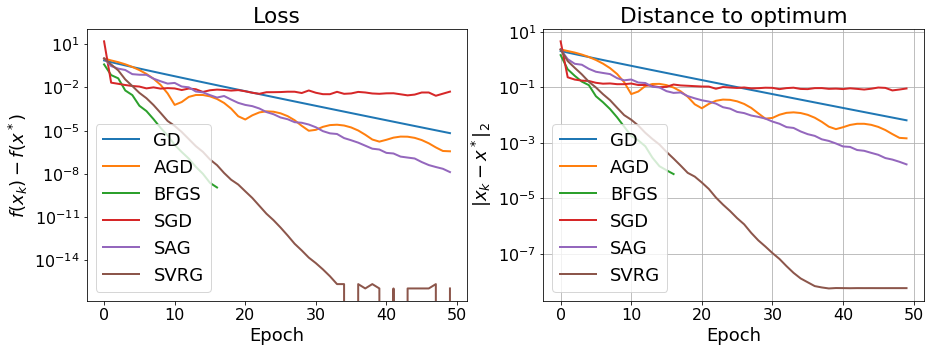

In [47]:
n = 10000
D = [10,100]
for u in D:
    d = u 
    print('the number of features is  d = '+str(u))
    lbda = 1./np.sqrt(n)
    change_ridge_parameter(lbda, n_iter = 50, corr = 0.5, methods = [1,2,3,4,5,6], d = u)
    plt.show()

Having more features mostly reduces the performance of the algorithms : they all converge in a lesser number of epochs and to a minimizer closer to the true one. This is coherent with the idea that there are more parameters to learn when there are a lot of features.

We now try to change n by making it half and double what we previsouly had. 
First, we test for the deterministic methods. 

the number of samples is  n = 5000


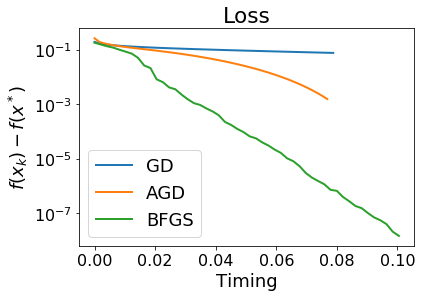

the number of samples is  n = 20000


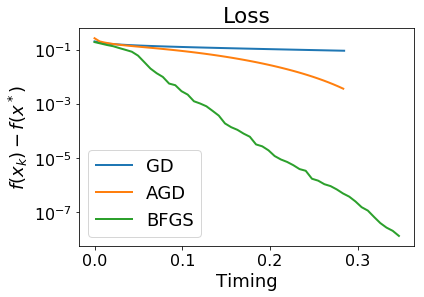

In [48]:
N = [5000,20000]
d = 50
for n in N:
    print('the number of samples is  n = '+ str(n))
    lbda = 1./np.sqrt(n)
    change_ridge_parameter(lbda, n_iter = 50, corr = 0.9, methods = [1,2,3], n = n, d = d,epochs = False, timing = True)
    plt.show()

The only difference here is obviously the computing time which is doubled because each gradient computed necessitates twice the amount of computation.
Now we try the stochastic methods: 

the number of samples is  n = 5000


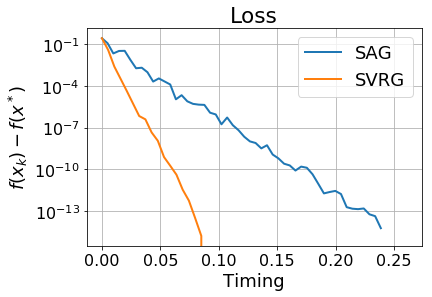

the number of samples is  n = 20000


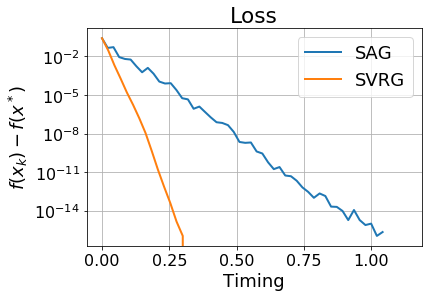

In [49]:
N = [5000,20000]
d = 50
for n in N:
    print('the number of samples is  n = '+ str(n))
    lbda = 1./np.sqrt(n)
    change_ridge_parameter(lbda, n_iter = 50, corr = 0.9, methods = [5,6], n = n, d = d,epochs = False, timing = True)
    plt.show()

Again here there isn't much change except for the computing time which we have plotted. The solution found is not better. Note: due to our implementation which does $n_{iter} \times n$ iterations, the stochastic algorithms make twice more iterations when there is twice as much data. 

### Question 13

According to what we've seen before:

**Correlation coefficient:**
- For a low correlation coefficient: 
The deterministic methods are more efficient than the stochastic methods (BFGS and AGD being the two best)
- For a high correlation coefficient:
The stochastic methods are more efficient than the determinst methods (SVRG and SAG being the two best)
the only method that is not really affected by a change in the correlation coefficient being SGD;

**Ridge Parameter**
The ridge parameter doesn't affect the convergences a lot.

**The number of samples**

Having many samples doesn't bring better results. Maybe when there are really few samples some algorithms perform better but we haven't tried that (it causes bugs actually).

**The number of features**

If the features are not too highly correlated, having many features complexifies the problem so the algorithms don't converge well.










### Question 14

$\underline{Deterministic~methods}$

For the Stochastic methods, their behavior are quite the same when we change the parameters $n$, $d$ and $corr$. However, when we change the ridge regularization parameter $ \lambda$ from Low to High Ridge, L-BFGS is the only one that is improving.

$\underline{Stochastic~methods}$

For the stochastic methods it's more complex:

When we change the ridge regularization parameter $ \lambda$ from Low to High, SAG and SVRG converge faster Whereas SGD doesn't change.

When the correlation coefficient $corr$ increases, SAG converges slower, SVRG converges faster and to a better minimizer and finally SAG behave the same.

When the number of features $d$ increases, SAG and SVRG converge slower but SGD converges towards a less accurate minimizer.

Finally, When the number of samples $n$ increases, all the stochastic curve methods behave the same.



### Question 15
Let's write a brief summary for each algorithm : 
* GD : one hyperparameter, computes a full gradient every iteration, very easy implementation.
* AGD : same thing 
* L-BFGS : apparently two hyperparameters (from the code), requires special properties for the function to optimize (it is a quasi-Newton method which we haven't studied yet though), complicated implemention probably.
* SGD : one hyperparameter $\eta_0$, very simple implementation, gradients for one data computed evey iteration
* SAG : one hyperparameter, stores n non-full gradients, computes a new one every iteration, relatively simple implementation.
* SVRG : one hyperparameter, stores one full gradient every n iterations, computes a non-full gradient every iteration, not so easy implementation.

Whether to choose a stochastic or deterministic algorithm depends much on the computer in use: a machine with high processing power but low memory should favor deterministic algorithms since it will be capable of calculating the full gradients but couldn't store intermediate gradients as sophisticated stochastic methods will do. On the opposite a machine with a lot of memory but unable to perform fast computations should privilege stochastic methods. 

Remarks: 
There doesn't seem to be a reason not to choose AGD over GD in any case since it will compute better every time and only requires one more line of code.
L-BFGS is very good but probably hard to implement and if one doesn't have time to find the two hyperparameters but still wants to go faster that GD and AGD, SAG will be a better choice.